In [20]:
import warnings
warnings.filterwarnings('ignore')

In [21]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [22]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [23]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [24]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [25]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [26]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [27]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement

In [28]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [29]:
# Import inspect from SQLAlchemy and find column names to help narrow down query
from sqlalchemy import inspect
inspector = inspect(engine)

measurement_columns = inspector.get_columns("measurement")
for c in measurement_columns:
    print(c["name"], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [30]:
station_columns = inspector.get_columns("station")
for c in station_columns:
    print(c["name"], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [31]:
# Find the most recent date in the data set.
most_recent_date = session.query(measurement.date).\
    order_by(measurement.date.desc()).first()[0]
print(most_recent_date)

2017-08-23


<Axes: xlabel='Date', ylabel='Inches'>

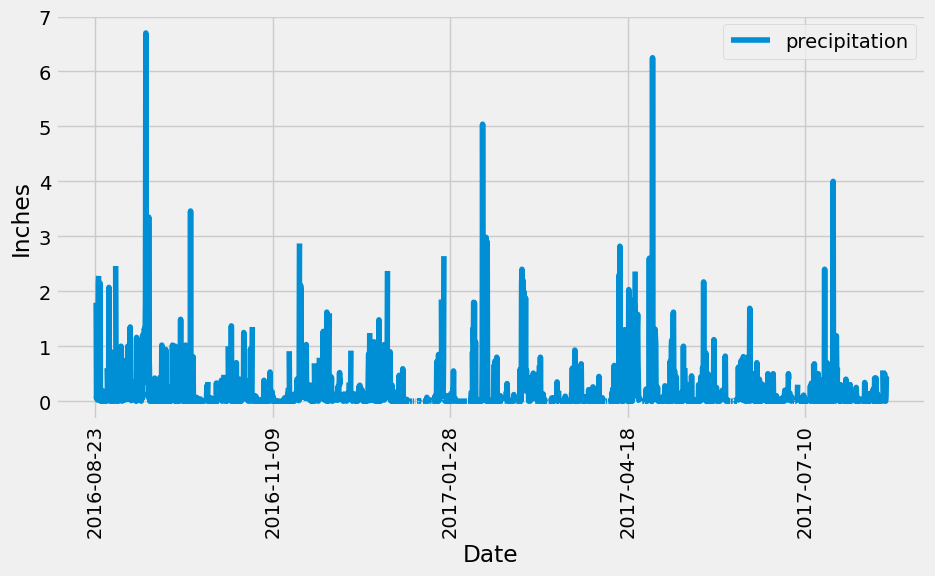

In [32]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
first_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
last_12 = session.query(measurement.date, measurement.prcp).filter(measurement.date >= first_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(last_12, columns=['date','precipitation'])
df.set_index('date', inplace=True)
# Sort the dataframe by date
df = df.sort_values(by='date')

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(rot=90, xlabel = 'Date', ylabel='Inches', figsize=(10,5))

In [33]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [34]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(func.count(station.station)).first()[0]
station_count

9

In [35]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_count = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).all()
station_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [36]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
lowest_temp = session.query(func.min(measurement.tobs)).filter(measurement.station == 'USC00519281').first()
highest_temp = session.query(func.max(measurement.tobs)).filter(measurement.station == 'USC00519281').first()
average_temp = session.query(func.avg(measurement.tobs)).filter(measurement.station == 'USC00519281').first()
print(lowest_temp, highest_temp, average_temp)

(54.0,) (85.0,) (71.66378066378067,)


Text(0.5, 0, 'Temperature')

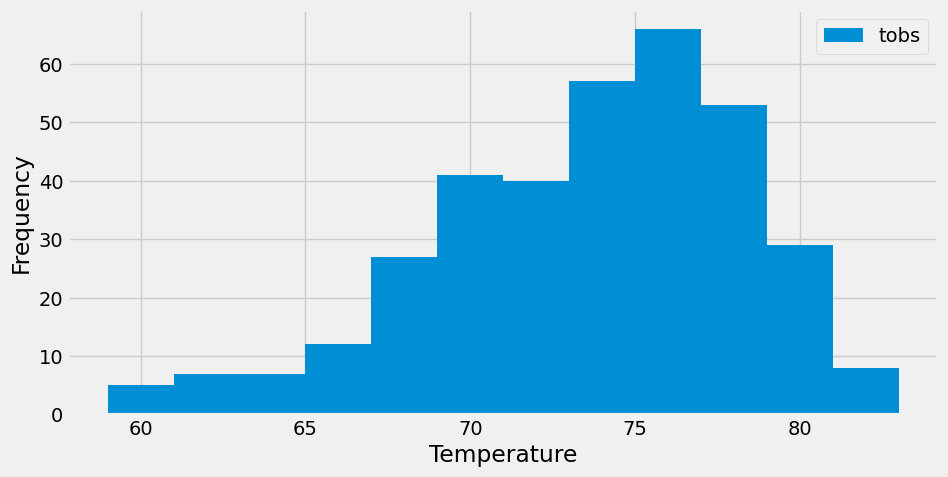

In [37]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
data = session.query(measurement.tobs).\
        filter(measurement.station == 'USC00519281').\
        filter(measurement.date >= first_date).all()
station_df = pd.DataFrame(data, columns=['tobs'])

station_df.plot.hist(bins=12, figsize=(10, 5))
plt.xlabel('Temperature')

# Close Session

In [38]:
# Close Session
session.close()